INFORMAÇÕES DO DATASET

Shape: (584227, 20)
Features: 19 (+ Label)
Duplicatas: 0

Distribuição de classes:
Label 0 (Benigno): 535,925 (91.73%)
Label 1 (Ataque):  48,302 (8.27%)

CROSS-VALIDATION - RANDOM FOREST
(supervised anomaly detection)

Treinando Random Forest com Cross-Validation (5 folds)...

Resultados Random Forest:

ACCURACY     Treino: 0.9990 | Teste: 0.9989 (±0.0001)
PRECISION    Treino: 0.9881 | Teste: 0.9873 (±0.0017)
RECALL       Treino: 0.9999 | Teste: 0.9995 (±0.0002)
F1           Treino: 0.9940 | Teste: 0.9934 (±0.0008)
ROC_AUC      Treino: 0.9994 | Teste: 0.9992 (±0.0001)
PR_AUC       Treino: 0.9880 | Teste: 0.9869 (±0.0016)

Gerando matriz de confusão (Random Forest)...


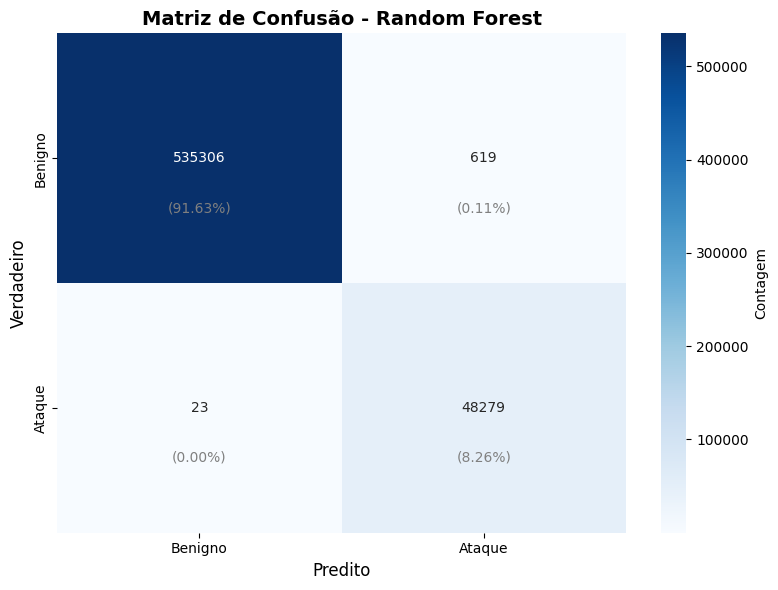


True Negatives:  535,306
False Positives: 619
False Negatives: 23
True Positives:  48,279

CROSS-VALIDATION - ISOLATION FOREST

O Isolation Forest é treinado APENAS com dados benignos
    (unsupervised anomaly detection)

Treinando Isolation Forest com Cross-Validation (5 folds)...

Resultados Isolation Forest:

ACCURACY     Média = 0.9258 | Desvio padrão = 0.0018
PRECISION    Média = 0.6188 | Desvio padrão = 0.0214
RECALL       Média = 0.2648 | Desvio padrão = 0.0208
F1           Média = 0.3707 | Desvio padrão = 0.0240
ROC_AUC      Média = 0.6251 | Desvio padrão = 0.0104
PR_AUC       Média = 0.2250 | Desvio padrão = 0.0164


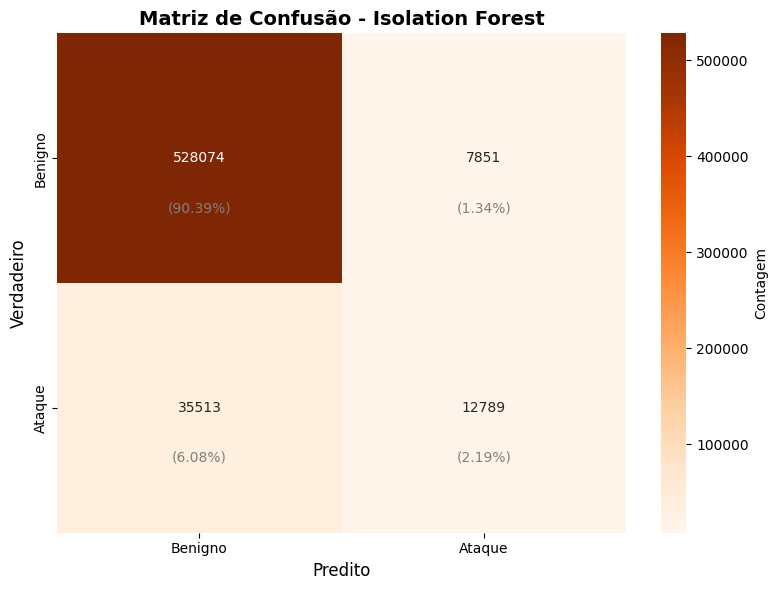


True Negatives:  528,074
False Positives: 7,851
False Negatives: 35,513
True Positives:  12,789

COMPARAÇÃO ENTRE MODELOS

   Métrica  Random Forest  Isolation Forest
 accuracy       0.998901          0.925775
precision       0.987344          0.618801
   recall       0.999524          0.264772
       f1       0.993396          0.370674
  roc_auc       0.999184          0.625061
   pr_auc       0.986913          0.225037


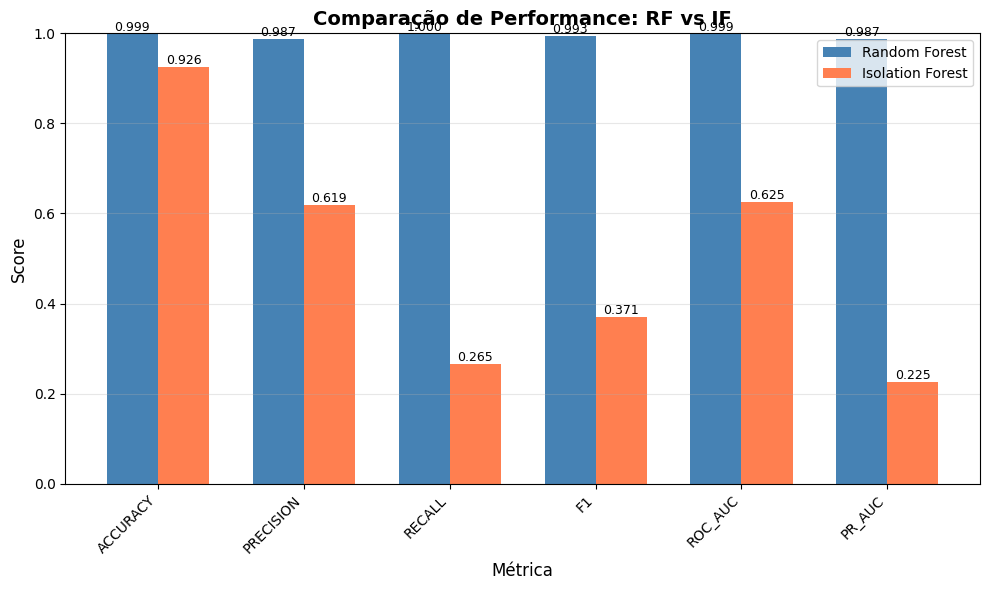


PROCESSAMENTO CONCLUÍDO!


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    make_scorer, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix
)

# -----------------------------
# Carregar dataset
# -----------------------------
df = pd.read_csv('Dataset/df_sample.csv')
print("=" * 70)
print("INFORMAÇÕES DO DATASET")
print("=" * 70)
print(f"\nShape: {df.shape}")
print(f"Features: {df.shape[1] - 1} (+ Label)")
print(f"Duplicatas: {df.duplicated().sum()}")

# -----------------------------
# Separar features e target
# -----------------------------
X = df.drop(columns=['Label'])
y = df['Label']

# -----------------------------
# Verificar distribuição de classes
# -----------------------------
print(f"\nDistribuição de classes:")
print(f"Label 0 (Benigno): {(y == 0).sum():,} ({100*(y == 0).sum()/len(y):.2f}%)")
print(f"Label 1 (Ataque):  {(y == 1).sum():,} ({100*(y == 1).sum()/len(y):.2f}%)")

# -----------------------------
# Funções de métricas
# -----------------------------
def if_precision(y_true, y_pred): return precision_score(y_true, y_pred, zero_division=0)
def if_recall(y_true, y_pred): return recall_score(y_true, y_pred, zero_division=0)
def if_f1(y_true, y_pred): return f1_score(y_true, y_pred, zero_division=0)
def if_roc_auc(y_true, y_pred): return roc_auc_score(y_true, y_pred)
def if_pr_auc(y_true, y_pred): return average_precision_score(y_true, y_pred)

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(if_precision),
    'recall': make_scorer(if_recall),
    'f1': make_scorer(if_f1),
    'roc_auc': make_scorer(if_roc_auc),
    'pr_auc': make_scorer(if_pr_auc)
}

print("\n" + "=" * 70)
print("CROSS-VALIDATION - RANDOM FOREST")
print("=" * 70)
print("(supervised anomaly detection)")

# -----------------------------
# Random Forest com StratifiedKFold
# -----------------------------
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,           
    min_samples_split=5,    
    min_samples_leaf=2,     
    class_weight='balanced', 
    random_state=42,
    n_jobs=-1
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nTreinando Random Forest com Cross-Validation (5 folds)...")
rf_scores = cross_validate(rf, X, y, cv=cv, scoring=scoring, return_train_score=True)

print("\nResultados Random Forest:\n")
for metric in scoring.keys():
    train_mean = np.mean(rf_scores[f'train_{metric}'])
    test_mean = np.mean(rf_scores[f'test_{metric}'])
    test_std = np.std(rf_scores[f'test_{metric}'])
    print(f"{metric.upper():<12} Treino: {train_mean:.4f} | Teste: {test_mean:.4f} (±{test_std:.4f})")

# -----------------------------
# Matriz de Confusão - Random Forest
# -----------------------------
print("\nGerando matriz de confusão (Random Forest)...")
rf_preds = np.zeros(len(y))
for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    rf.fit(X_train, y_train)
    rf_preds[test_idx] = rf.predict(X_test)

rf_cm = confusion_matrix(y, rf_preds)

# Gráfico da matriz de confusão - Random Forest
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benigno', 'Ataque'],
            yticklabels=['Benigno', 'Ataque'],
            cbar_kws={'label': 'Contagem'})
plt.title('Matriz de Confusão - Random Forest', fontsize=14, fontweight='bold')
plt.ylabel('Verdadeiro', fontsize=12)
plt.xlabel('Predito', fontsize=12)

# Adicionar percentuais
total = rf_cm.sum()
for i in range(2):
    for j in range(2):
        percentage = (rf_cm[i, j] / total) * 100
        plt.text(j+0.5, i+0.7, f'({percentage:.2f}%)', 
                ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.show()

tn, fp, fn, tp = rf_cm.ravel()
print(f"\nTrue Negatives:  {tn:,}")
print(f"False Positives: {fp:,}")
print(f"False Negatives: {fn:,}")
print(f"True Positives:  {tp:,}")

# =====================================================================
# ======================  ISOLATION FOREST ============================
# =====================================================================

print("\n" + "=" * 70)
print("CROSS-VALIDATION - ISOLATION FOREST")
print("=" * 70)
print("\nO Isolation Forest é treinado APENAS com dados benignos")
print("    (unsupervised anomaly detection)")

# Treinar apenas em dados benignos
X_benign = X[y == 0]

# Padronizar (IMPORTANTE para IF!)
scaler = StandardScaler()
X_benign_scaled = scaler.fit_transform(X_benign)
X_scaled = scaler.transform(X)

# hiperparametros
iso = IsolationForest(
    n_estimators=500,        
    max_samples=0.6,         
    contamination='auto',      
    bootstrap=True,         
    random_state=42,
    n_jobs=-1
)

iso_metrics = {m: [] for m in scoring.keys()}
iso_preds = np.zeros(len(y))

print("\nTreinando Isolation Forest com Cross-Validation (5 folds)...")

# Cross-validation manual (estratificada)
for fold, (train_idx, test_idx) in enumerate(cv.split(X_scaled, y), 1):
    X_train = X_scaled[train_idx]
    y_train = y.iloc[train_idx]

    # Treina apenas com benignos do fold
    X_train_benign = X_train[y_train == 0]
    iso.fit(X_train_benign)

    X_test = X_scaled[test_idx]
    y_test = y.iloc[test_idx]

    pred = iso.predict(X_test)
    pred = np.where(pred == -1, 1, 0)  # -1 → ataque (1), 1 → benigno (0)
    iso_preds[test_idx] = pred

    # Métricas
    iso_metrics['accuracy'].append(np.mean(pred == y_test))
    iso_metrics['precision'].append(precision_score(y_test, pred, zero_division=0))
    iso_metrics['recall'].append(recall_score(y_test, pred, zero_division=0))
    iso_metrics['f1'].append(f1_score(y_test, pred, zero_division=0))
    iso_metrics['roc_auc'].append(roc_auc_score(y_test, pred))
    iso_metrics['pr_auc'].append(average_precision_score(y_test, pred))


# -----------------------------
# RELATÓRIO FINAL - ISOLATION FOREST
# -----------------------------
print("\nResultados Isolation Forest:\n")
for metric in scoring.keys():
    mean = np.mean(iso_metrics[metric])
    std = np.std(iso_metrics[metric])
    print(f"{metric.upper():<12} Média = {mean:.4f} | Desvio padrão = {std:.4f}")

# -----------------------------
# Matriz de Confusão - Isolation Forest
# -----------------------------
iso_cm = confusion_matrix(y, iso_preds)

# Gráfico da matriz de confusão - Isolation Forest
plt.figure(figsize=(8, 6))
sns.heatmap(iso_cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Benigno', 'Ataque'],
            yticklabels=['Benigno', 'Ataque'],
            cbar_kws={'label': 'Contagem'})
plt.title('Matriz de Confusão - Isolation Forest', fontsize=14, fontweight='bold')
plt.ylabel('Verdadeiro', fontsize=12)
plt.xlabel('Predito', fontsize=12)

# Adicionar percentuais
total = iso_cm.sum()
for i in range(2):
    for j in range(2):
        percentage = (iso_cm[i, j] / total) * 100
        plt.text(j+0.5, i+0.7, f'({percentage:.2f}%)', 
                ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.show()

tn, fp, fn, tp = iso_cm.ravel()
print(f"\nTrue Negatives:  {tn:,}")
print(f"False Positives: {fp:,}")
print(f"False Negatives: {fn:,}")
print(f"True Positives:  {tp:,}")

# =====================================================================
# COMPARAÇÃO FINAL
# =====================================================================
print("\n" + "=" * 70)
print("COMPARAÇÃO ENTRE MODELOS")
print("=" * 70)

comparison = pd.DataFrame({
    'Métrica': list(scoring.keys()),
    'Random Forest': [np.mean(rf_scores[f'test_{m}']) for m in scoring.keys()],
    'Isolation Forest': [np.mean(iso_metrics[m]) for m in scoring.keys()]
})

print("\n", comparison.to_string(index=False))

# Gráfico comparativo
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(scoring))
width = 0.35

rf_means = [np.mean(rf_scores[f'test_{m}']) for m in scoring.keys()]
iso_means = [np.mean(iso_metrics[m]) for m in scoring.keys()]

bars1 = ax.bar(x - width/2, rf_means, width, label='Random Forest', color='steelblue')
bars2 = ax.bar(x + width/2, iso_means, width, label='Isolation Forest', color='coral')

ax.set_xlabel('Métrica', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Comparação de Performance: RF vs IF', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.upper() for m in scoring.keys()], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# Adicionar valores nas barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("PROCESSAMENTO CONCLUÍDO!")
print("=" * 70)